In [1]:
import pickle
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from scipy.special import kn,zetac
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))
from scipy.interpolate import interp1d

In [2]:
f = open('gFunctions.pcl','rb')
gSTAR = pickle.load(f)
gSTARS = pickle.load(f)
Tfunc = pickle.load(f)
f.close()

In [3]:
@np.vectorize
def H(T):
    MP = 1.22*10**19
    rhoRad = (np.pi**2/30)*gSTAR(T)*T** 4  # thermal bath's energy density    
    H = np.sqrt(8*np.pi*rhoRad/3)/MP
    
    return H

@np.vectorize
def nEQ(T,dof,mass):
    """Returns the equilibrium number density at temperature T. Returns zero for non-thermal components"""

    Zeta3 = zetac(3.) + 1.

    x = T/mass
    if x < 0.1:
        neq = mass**3*(x/(2*np.pi))**(3./2.)*np.exp(-1/x)*(1. + (15./8.)*x + (105./128.)*x**2) #Non-relativistic
    elif x < 1.5:            
        neq = mass**3*x*kn(2,1/x)/(2*np.pi**2) #Non-relativistic/relativistic
    else:
        if dof > 0: neq = Zeta3*T**3/np.pi**2   #Relativistic Bosons
        if dof < 0: neq = (3./4.)*Zeta3*T**3/np.pi**2   #Relativistic Fermions

    neq = neq*abs(dof)
    return neq

#Annihilation rate for mediator
data = np.genfromtxt('./width_and_medxs.dat',skip_header=5)
dataR = np.genfromtxt('./sigmav_conversion_bchi-sbotg_500_510_1.dat',skip_header=6,usecols=(0,4))
conv = 0.8579e17

sLog = lambda x: interp1d(data[:,0],np.log(data[:,1]*conv),
                    fill_value='extrapolate',bounds_error=False)(x)

#Conversion rates for DM and mediator: 
dofDM = -2 #Number of DM degrees of freedom (Majorana fermion)

@np.vectorize
def sigmaVJan(T):
    x = 500./T
    if x > data[:,0].max():
        return 0.
    sF = sLog(x)
    return np.exp(sF)


In [4]:
with open('result_FO.dat','r') as f:
    omega = eval([l for l in f.readlines() if 'DM' in l and l[0] == '#'][0].split('Omega h^2 (@TF) =')[-1])

In [5]:
skiplines = 8
d = np.genfromtxt('result_FO.dat',names=True,skip_header=skiplines)

In [6]:
print(d.dtype.names)

('x', 'T', 'R', 'S', 'n_DM', 'rho_DM')


In [7]:
newtype = np.dtype(d.dtype.descr + [('H', '<f8'),('s','<f8'),('neq_DM', '<f8')])
newdata = np.zeros(d.shape, dtype=newtype)
for name in d.dtype.names:
    newdata[name] = d[name]
newdata['H'] = H(d['T'])
newdata['s'] = gSTARS(d['T'])*(d['T']**3)
newdata['neq_DM'] = nEQ(d['T'],-2,500.)
d = newdata

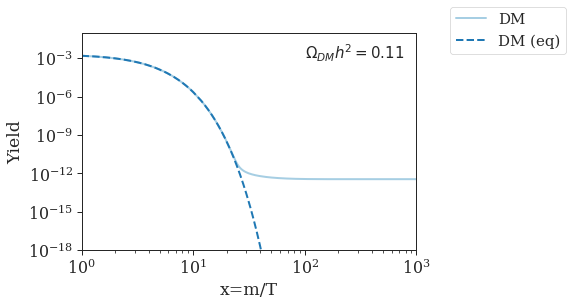

In [8]:
plt.plot(500./d['T'],d['n_DM']/d['s'],label='DM',linewidth=2)
plt.plot(500./d['T'],d['neq_DM']/d['s'],'--',label='DM (eq)',linewidth=2)
plt.xscale('log')
plt.yscale('log')
lgd = plt.legend(loc=(1.1,0.9),fontsize=15)
plt.ylim(1e-18,1e-1)
plt.xlim(1,1000)
plt.xlabel('x=m/T')
plt.ylabel('Yield')
plt.text(100.,1e-3,s=r'$\Omega_{DM} h^2 = %1.3g$' %omega,fontsize=15)
# plt.savefig("Yield_noConversion.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()